# Interpreting SqueezeNet1.1 trained to detect defects in steel sheet 

### 1. Requirments

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import cv2
import torch
import shap
from lime import lime_image

sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')
import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

from tqdm import tqdm
from torchvision import models
from torch import nn
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc

In [2]:
### Fast import of Captum Algorithm
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    GuidedGradCam,
    GuidedBackprop,
    LayerGradCam,
    visualization
)

### 2. Parameters

In [3]:
MODEL_PATH = '../model/OfficialMultiModels/MultiAugmentedSqueezeReduced.pth'

IMAGE_PATH = '../data/train_images'
DATA_PATH = '../data/multiData'
METADATA_PATH = '../data/multiData/test_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_test.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_test.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_test.pth'

In [4]:
n_classes = 5
class_labels = {0: 'No Defects', 1: 'Type 1', 2: 'Type 2', 3: 'Type 3', 4: 'Type 4'}
params = c_utils.get_default_params()
device = torch.device('cuda')
#warnings.filterwarnings("ignore")

### 3. Data
#### 3.1 Load data
Since retrieving all the batches using dataloader has been quite slow and created problem in Colab, a procedure to generate the full torch matrix (input, labels and masks) from the images should be performed to run this jupyter smoothly. If the INPUT, MASK and LABEL matrix are already present in the given paths we just load them

In [5]:
### Check if the given paths exists
if DATA_PATH.split('/')[1] not in os.listdir(DATA_PATH.split('/')[0]): # Create folder if it does not exists
    os.mkdir(DATA_PATH) 
c1 = INPUT_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c2 = LABEL_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c3 = MASK_PATH.split('/')[-1] in os.listdir(DATA_PATH)

In [6]:
### If the path are present we load the matrix, else we generate them
if c1 and c2 and c3:
    print('Data is present and ready to be loaded')
    X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)
else:
    print('Starting process to create matrices...')
    time.sleep(0.1)
    X_val, y_val, M_val = c_utils.create_data(IMAGE_PATH, METADATA_PATH, 
                                              batch_size=200, num_workers=0, 
                                              return_mask=True, params=params)

Data is present and ready to be loaded


#### 3.2 Visualize data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


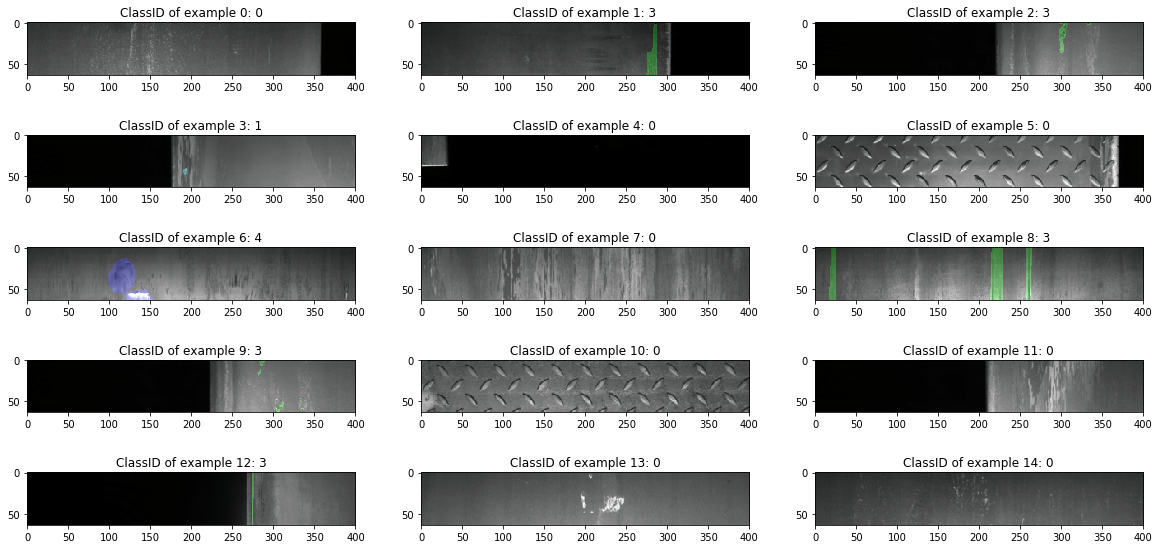

In [7]:
fig, ax = plt.subplots(5, 3, figsize=(20, 10))
start = 0
for i in range(start, start+15):
    img = np.transpose(X_val[i].numpy(), (1, 2, 0))*params['std'] + params['mean']
    mask = M_val[i].reshape(*params['size'])
    if y_val[i] > 0:
        img[mask == 1] = img[mask == 1] + params['colors'][y_val[i]-1]
    ax[(i-start)//3, (i-start)%3].set_title('ClassID of example {}: {}'.format(i, y_val[i]))
    ax[(i-start)//3, (i-start)%3].imshow(img)
plt.show()

### 4. Model

    a) Load Squeeze architecture
    b) Modify the classifier architecture
    c) Load the parameters
    d) Move model in GPU

In [8]:
### 4.1 Load architecture
net = models.squeezenet1_1(pretrained=True)
net.features = net.features[:10]
net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, 5))#, nn.Softmax(dim=1))
net = net.to(device)
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [9]:
y_pred = []
y_true = []
y_score = torch.Tensor([])
batch_size = 2

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
        out = net(X)
        probs = out.detach().cpu()
        if type(net.classifier[-1]) != torch.nn.modules.activation.Softmax: 
            probs = nn.Softmax(dim=1)(out).detach().cpu()
        
        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])
        
y_score = y_score.numpy()
print('Accuracy: {:.4f}\tF1 Score: {:.4f}'.format(accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='weighted')))

100%|██████████████████████████████████████████████████████████████████████████████| 1214/1214 [00:25<00:00, 47.00it/s]

Accuracy: 0.9213	F1 Score: 0.9237


### 6. Interpretation

In [10]:
def visualize_input(n):
    fig, ax = plt.subplots(1, 1, fgsize=(14, 5))
    img = np.transpose(X_val[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
    mask = M_val[n].reshape(*params['size'])
    img[mask == 1] = img[mask == 1] + params['colors'][int(y_true[n])]
    ax.imshow(img)
    ax.set_title('True class: {}'.format(class_labels[int(y_true[n])]))

    print('The model predicted correctly:\t{}'.format(y_pred[n] == y_true[n]))
    print('Predicted No Defects with probability:\t{:.2f}'.format(y_score[n, 0]))
    print('Predicted Defects with probabability:\t{:.2f}'.format(y_score[n, 1]))
    plt.show()


def visualize_gradcam(n, module, out_type='id', normalizer=False, color_normalizer=True, return_output = False):
    ### 7.3.a) Show input image 
    fig = plt.figure(figsize = (13.3, 5))
    ax = fig.add_subplot(1, 1, 1)
    img = np.transpose(X_val[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
    if y_val[n] > 0:
        mask = M_val[n].reshape(*params['size'])
        img[mask == 1] = img[mask == 1] + params['colors'][int(y_true[n]-1)]
    ax.imshow(img)
    
    ax.set_title('Input image')

    ### 7.3.b) Initialize GradCam passing the network and the last Convolutional Layer and the results tensor
    grad_cam = c_explainers.GradCam(net, module, device)
    results = torch.Tensor([])    

    ### 7.3.c) Compute GradCam for both target (No Defect/Defect)
    for i in range(n_classes):
        ### 7.3.c.i)  Compute Grad Cam with out_type 'id'. It means that no ReLU operation is done on the GradCam output
        _, original_out = grad_cam(X_val[n], i, out_type='id', interpolation_mode = cv2.INTER_LANCZOS4,  additional_out = True)
        ### 7.3.c.ii) Save the results
        grad_cam_output = cv2.resize(original_out.numpy(), (25*16, 4*16))
        results = torch.cat([results, torch.tensor(grad_cam_output).unsqueeze(0)])

    ### 7.3.d) Normalize the results     
    if normalizer:
        gc_results = (results - torch.min(results)) / (torch.max(results) - torch.min(results))
        gc_results = gc_results*2 - 1
    else:
        gc_results = results

    ### 7.3.e) Show GradCam outcomes
    fig = plt.figure(figsize = (16.8, 3.0*n_classes))                            ### Set figure                   
    for j in range(n_classes):          
        ax = fig.add_subplot(n_classes, 1, j+1)                                  ### Addsubplot to figure
        img_input = gc_results[j].numpy()                                        ### Get normalized GradCam output
        img_input[0, 0] = 1
        img_input[0, 1] = -1

        ### 7.3.e.i)  Define MidPointNormalizer to avoid automatic rescaling
        vmin, vmax = np.min(img_input), np.max(img_input)
        vmean = np.mean([vmin, vmax])                
        normalizer = c_utils.MidpointNormalize(vmin = vmin, vmax = vmax, vcenter = vmean)

        ### 7.3.e.ii) Plot GradCam outcome and colorbar
        if color_normalizer:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r, norm=normalizer)
        else:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r)
        plt.colorbar(img, ax=ax)
        ax.set_title('GradCAM: probability of {} = {:.3f}'.format(class_labels[j], float(y_score[n, j])))
    plt.show()
    return gc_results

def visualize_deeplift(n, normalizer=False, color_normalizer=True):
    ### 8.1.a) Show input image 
    fig = plt.figure(figsize = (13.3, 5))
    ax = fig.add_subplot(1, 1, 1)
    img = np.transpose(X_val[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
    if y_val[n] > 0:
        mask = M_val[n].reshape(*params['size'])
        img[mask == 1] = img[mask == 1] + params['colors'][int(y_true[n]-1)]
    ax.imshow(img)
    ax.set_title('Input image')

    ### 8.1.b) Initialize DeepLift passing the network, initialize the baseline
    dl = DeepLift(net)
    #baseline = torch.zeros((1, 3, 64, 400)).to(device)
    #baseline.requires_grad = True
    baseline = np.transpose(X_val[n].clone().numpy(), (1, 2, 0))
    baseline = cv2.blur(baseline, (3, 3))
    baseline = torch.tensor(np.transpose(baseline, (2, 0, 1))).unsqueeze(0).to(device)
    results = torch.Tensor([])
    deltas = []

    ### 8.1.c) Compute DeepLift for both target (No Defect/Defect)
    for i in range(n_classes):
        ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
        output, delta = dl.attribute(X_val[n].view(1, *X_val[n].size()).to(device), baseline, i, return_convergence_delta=True)
        ### 8.1.c.ii) Save the results
        deltas.append(float(delta))
        results = torch.cat((results, output.view(1, 3, 64, 400).detach().cpu()))

    ### 8.1.d) Normalize the results
    if normalizer:
        dl_results = ((results - torch.min(results)) / (torch.max(results) - torch.min(results))).mean(dim=1)
        dl_results = dl_results*2 - 1
    else:
        dl_results = results.mean(dim=1)
        
        
    ## 8.1.e) Show DeepLift outcomes
    fig = plt.figure(figsize = (16.8, 3.0*n_classes))                            ### Set figure                   
    for j in range(n_classes):          
        ax = fig.add_subplot(n_classes, 1, j+1)                                  ### Addsubplot to figure
        #img_input = np.transpose(dl_results[j].numpy(), (1, 2, 0))
        img_input = dl_results[j].numpy()
        img_input[0, 0] = 1
        img_input[0, 1] = -1

        ### 8.3.e.i)  Define MidPointNormalizer to avoid automatic rescaling
        vmin, vmax = np.min(img_input), np.max(img_input)
        vmean = np.mean([vmin, vmax])                
        normalizer = c_utils.MidpointNormalize(vmin = vmin, vmax = vmax, vcenter = vmean)
        
        ### 8.3.e.ii) Plot GradCam outcome and colorbar
        if color_normalizer:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r, norm=normalizer)
        else:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r)
        plt.colorbar(img, ax=ax)
        ax.set_title('GradCAM: probability of {} = {:.3f}'.format(class_labels[j], float(y_score[n, j])))
    plt.show()
    return dl_results

### GradCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


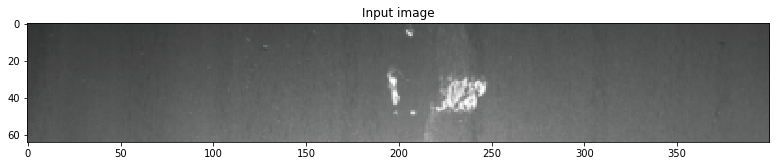

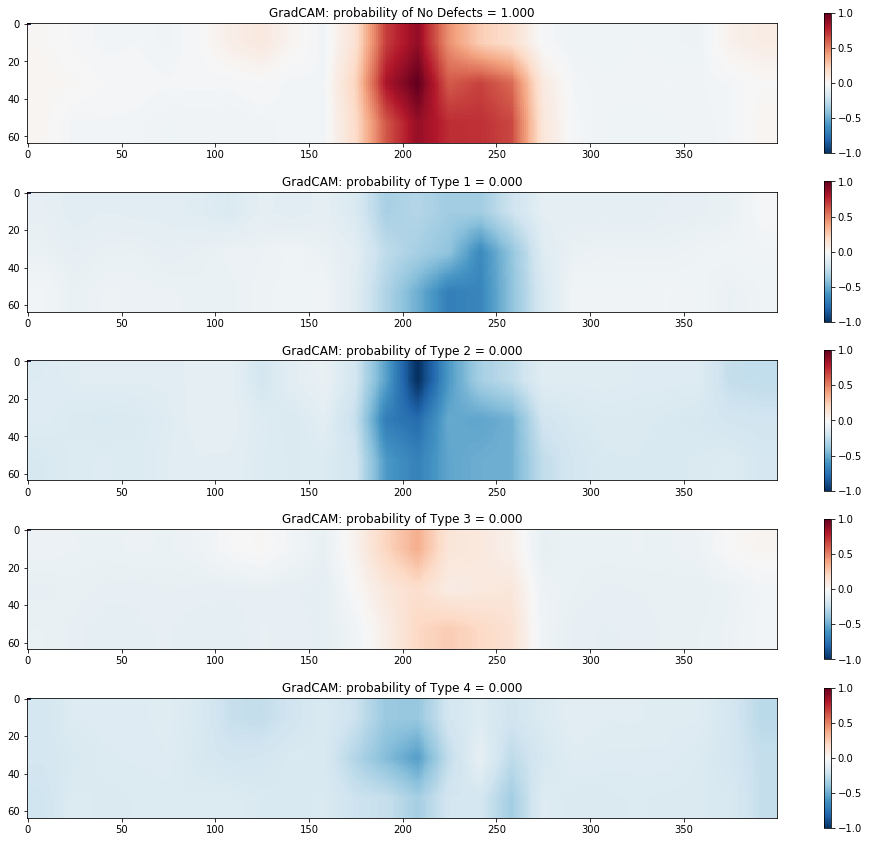

In [19]:
n = 13
print(y_val[n])
res = visualize_gradcam(n, module = net.classifier[1], normalizer=True, color_normalizer=False, return_output=True)

tensor(0)


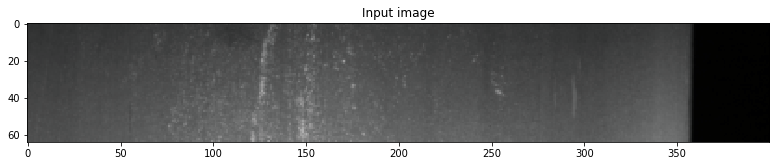

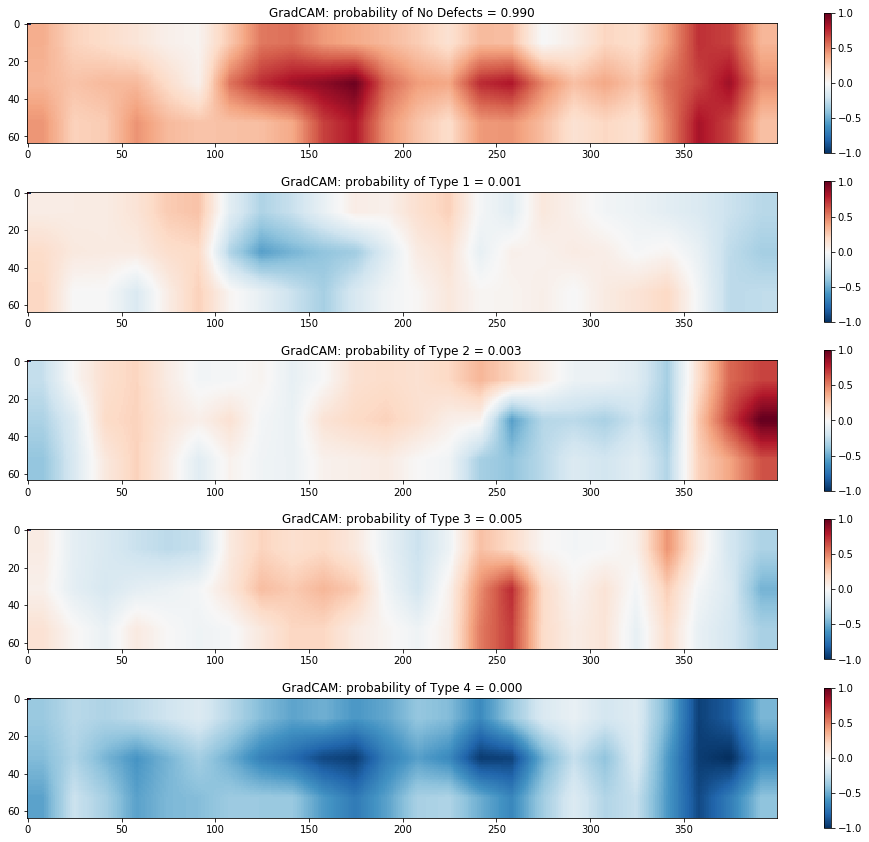

tensor(1)


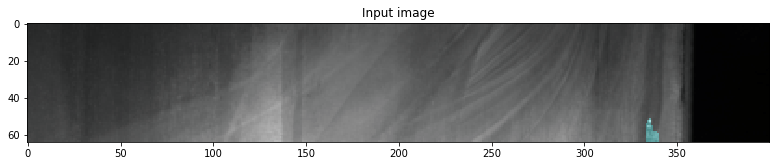

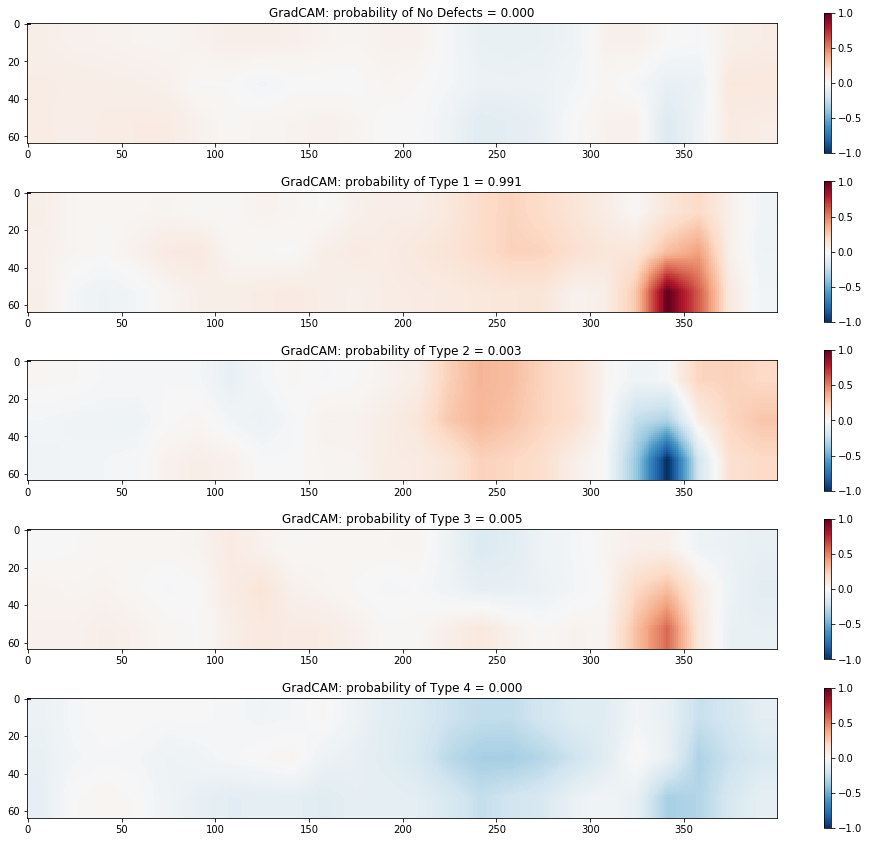

tensor(2)


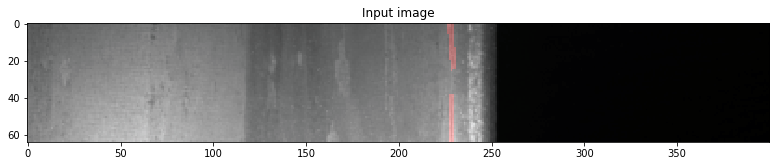

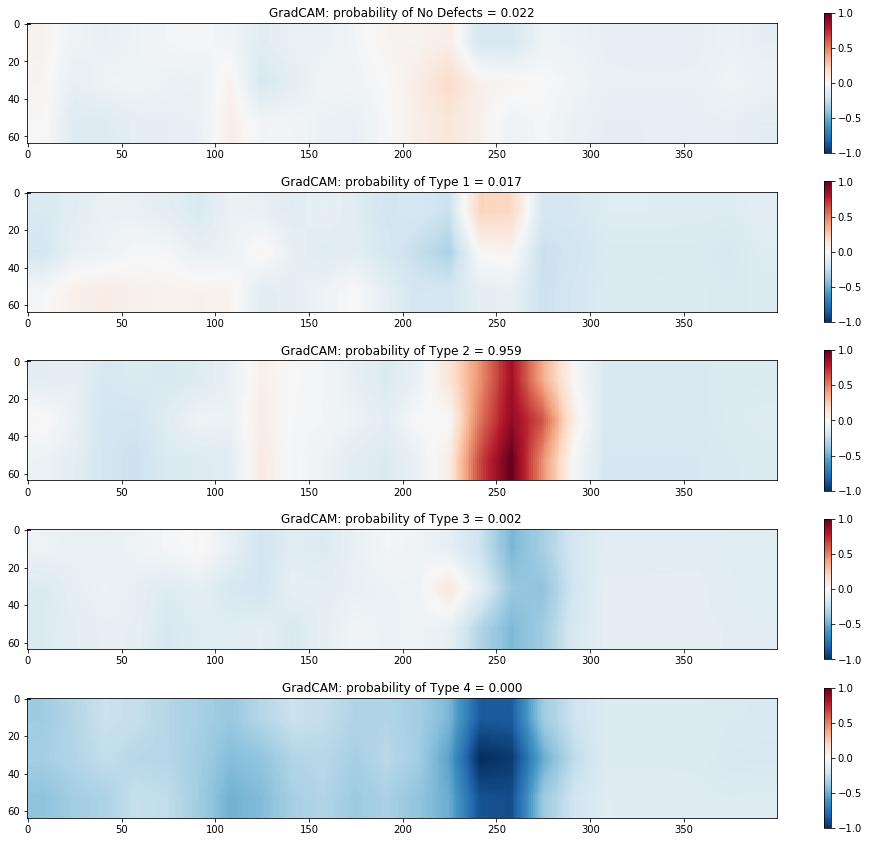

tensor(3)


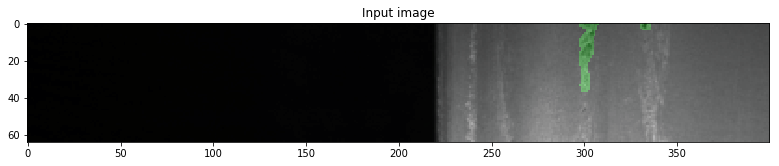

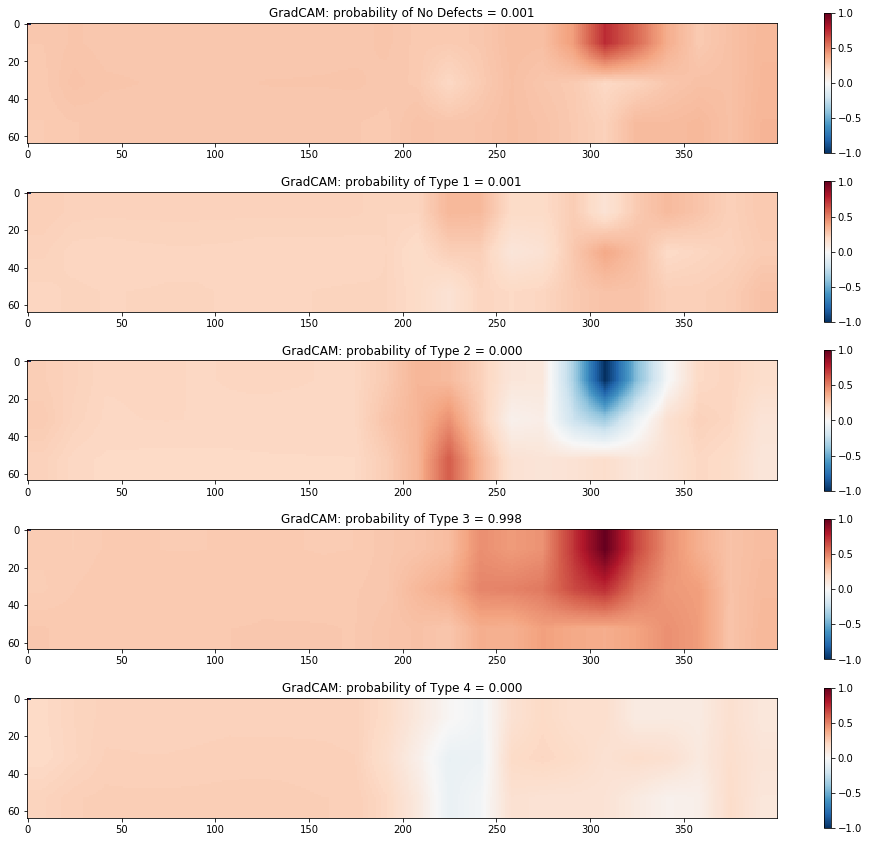

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(4)


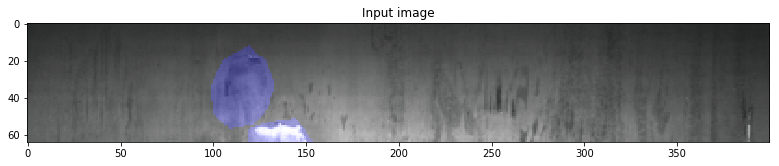

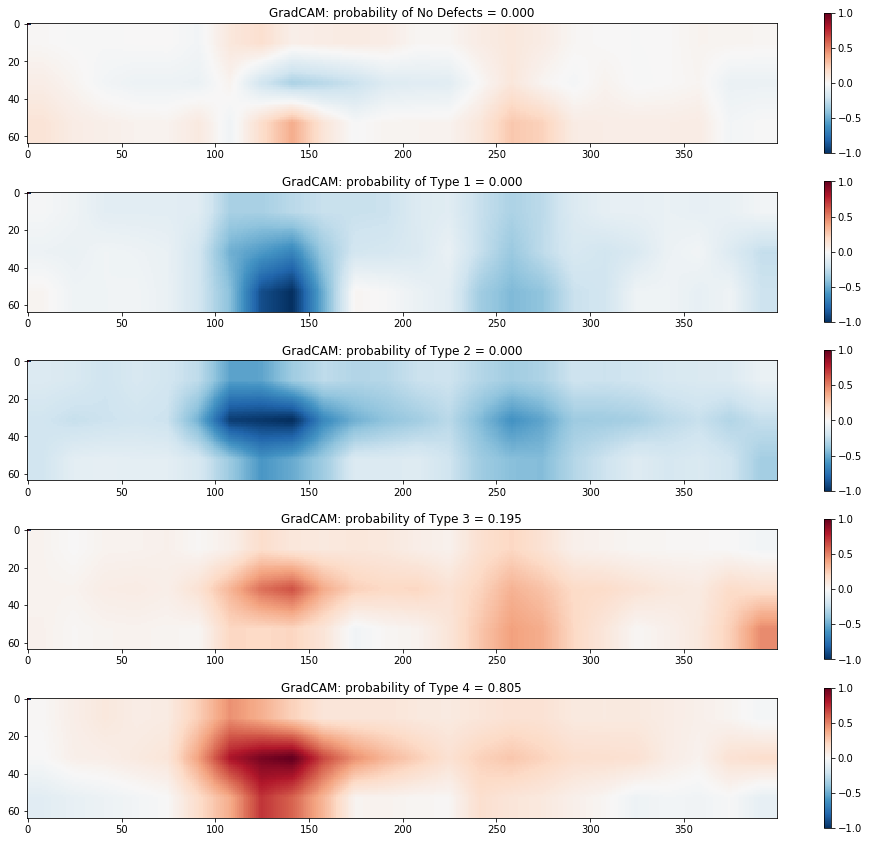

In [74]:
nice_ones = [0, 19, 158, 2, 6]
bad_ones = []
gc_result = []
eg_n = []
for n in nice_ones:
    print(y_val[n])
    res = visualize_gradcam(n, module = net.classifier[1], normalizer=True, color_normalizer=False, return_output=True)
    gc_result.append(res)
    eg_n.append(n)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


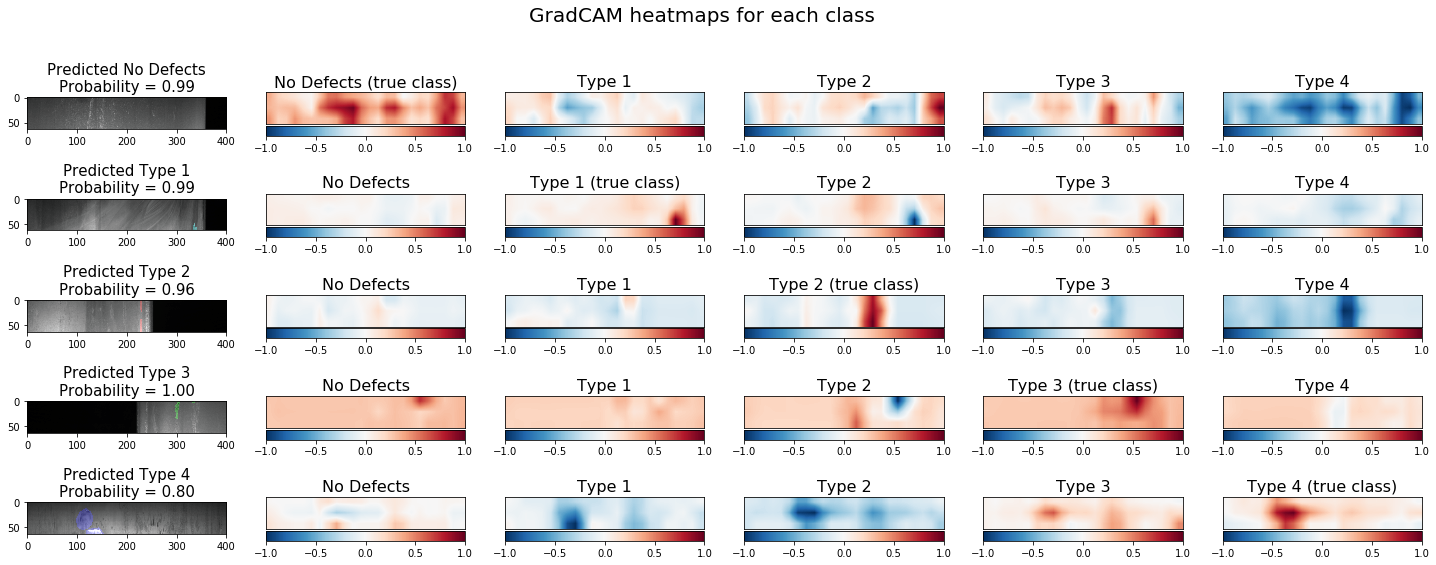

In [192]:
fig = plt.figure(figsize=(25, 9))
fig.suptitle('GradCAM heatmaps for each class', fontsize=20)

for j in range(len(gc_result)):
    ax0 = fig.add_subplot(len(gc_result), 6, j*6+1)
    img = np.transpose(X_val[eg_n[j]].numpy(), (1,2,0))*params['std'] + params['mean']
    if y_val[eg_n[j]] > 0:
        mask = M_val[eg_n[j]].reshape(*params['size'])
        img[mask == 1] = img[mask == 1] + params['colors'][int(y_true[eg_n[j]])-1]
    ax0.imshow(img)

    ax0.set_title('Predicted {}\nProbability = {:.2f}'.format(class_labels[y_pred[eg_n[j]]], 
                                                                  y_score[eg_n[j], int(y_pred[eg_n[j]])]),
                 fontsize=15)
    for i in range(5):
        ax1 = fig.add_subplot(len(gc_result), 6, j*6 + i+2)
        fax1 = ax1.imshow(gc_result[j][i], cmap=plt.cm.RdBu_r)
        plt.colorbar(fax1, ax=ax1, orientation='horizontal', fraction=0.35, pad=0.02)
        ax1.set_xticks([], [])
        ax1.set_yticks([], [])
        if y_val[eg_n[j]] == i:
            ax1.set_title('{} (true class)'.format(class_labels[i]), fontsize=16)
        else:
            ax1.set_title('{}'.format(class_labels[i]), fontsize=16)

### DeepLift

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Input Tensor 0 did not already require gradients, required_grads has been set automatically.


tensor(0)


Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished


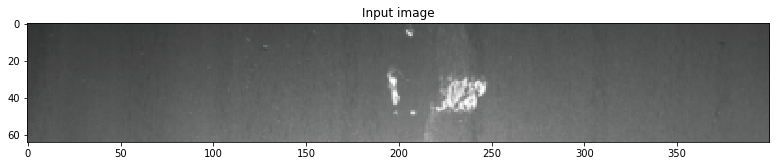

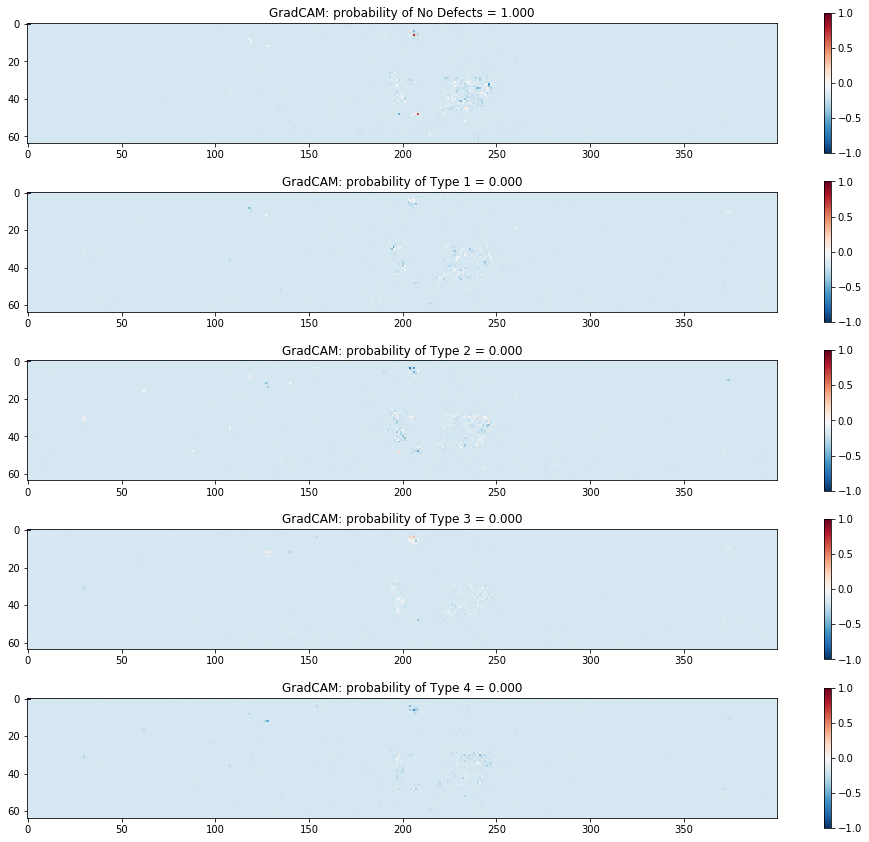

In [11]:
n = 13
print(y_val[n])
res = visualize_deeplift(n, normalizer=True, color_normalizer=False)

tensor(0)


Input Tensor 0 did not already require gradients, required_grads has been set automatically.
Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished


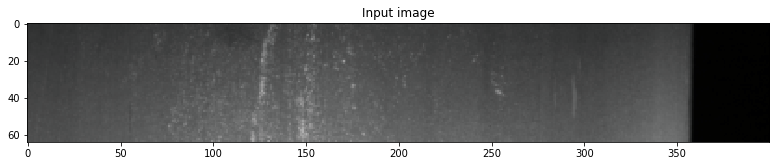

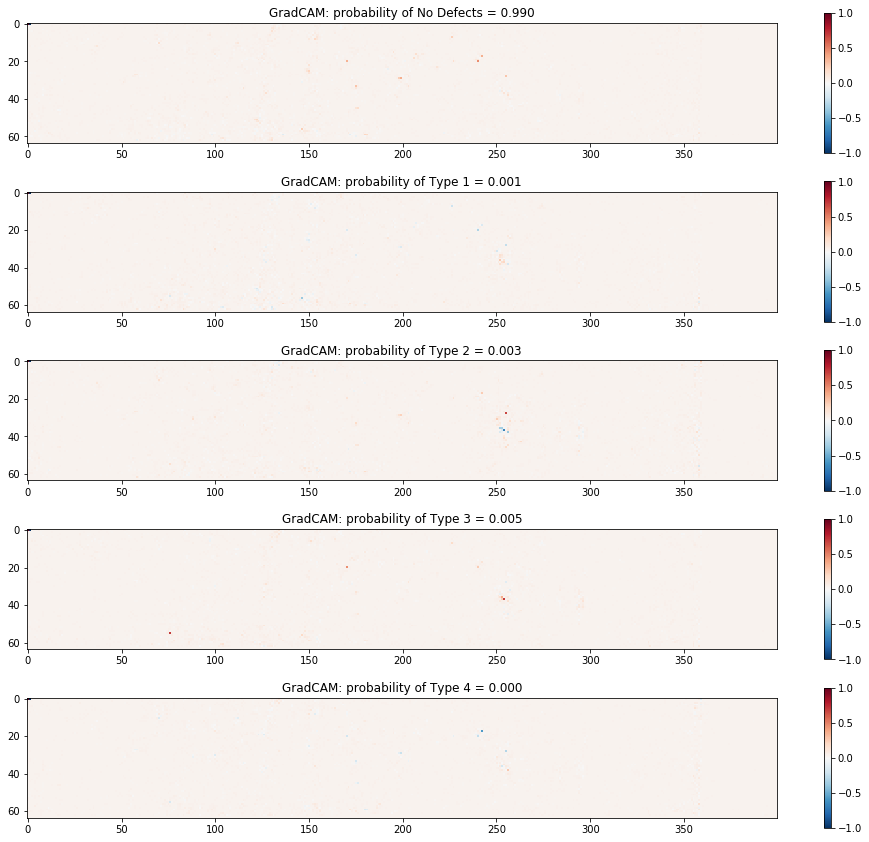

tensor(1)


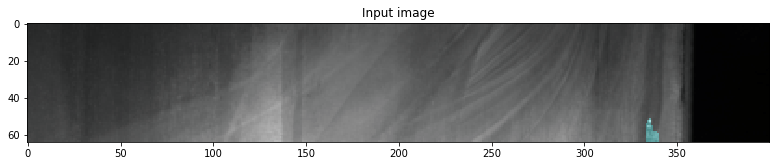

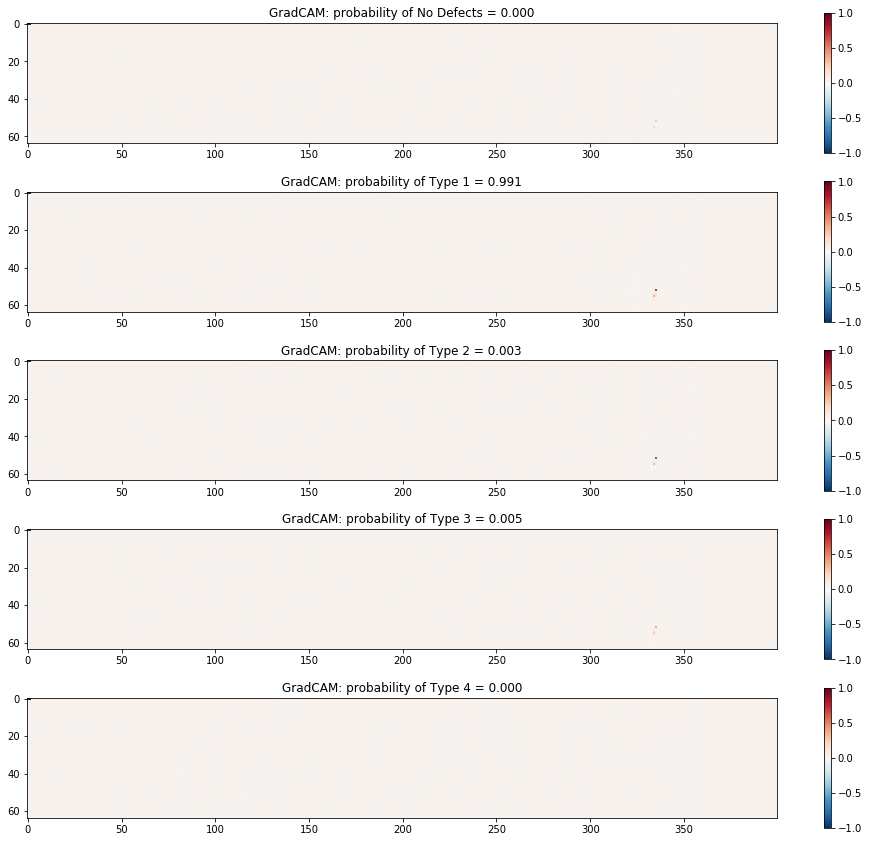

tensor(2)


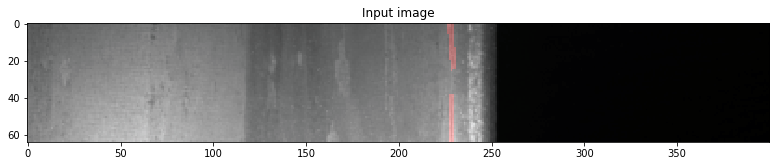

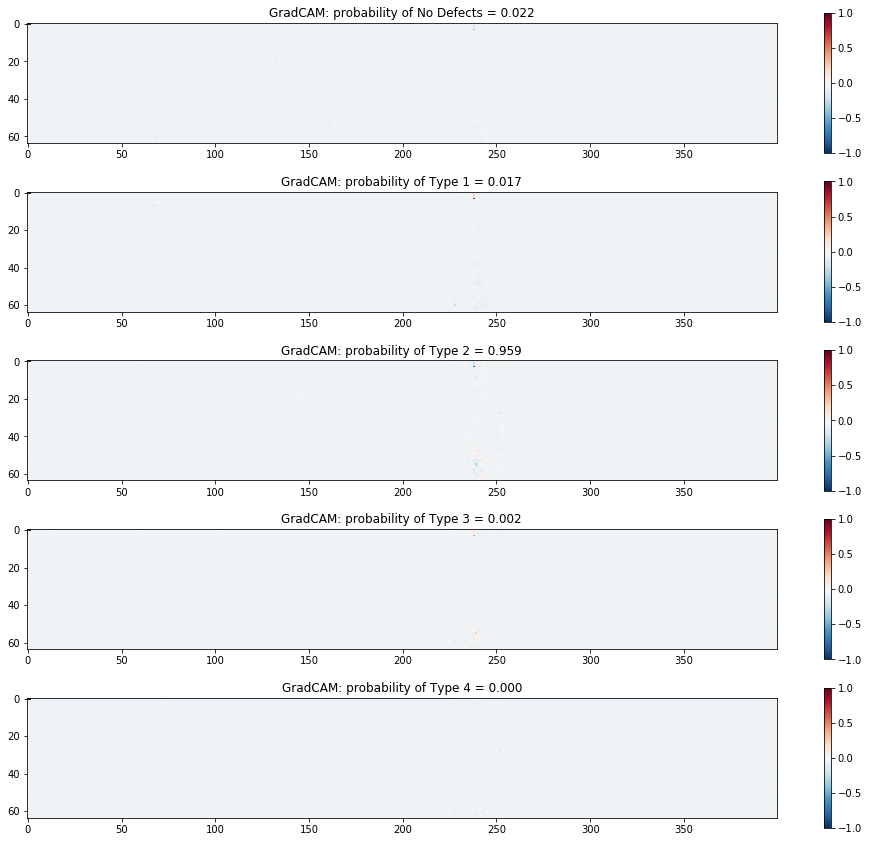

tensor(3)


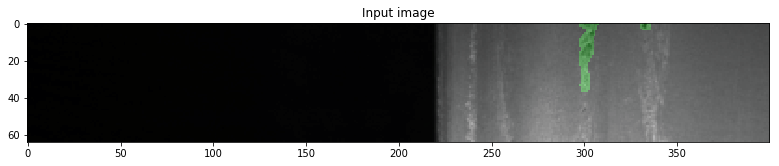

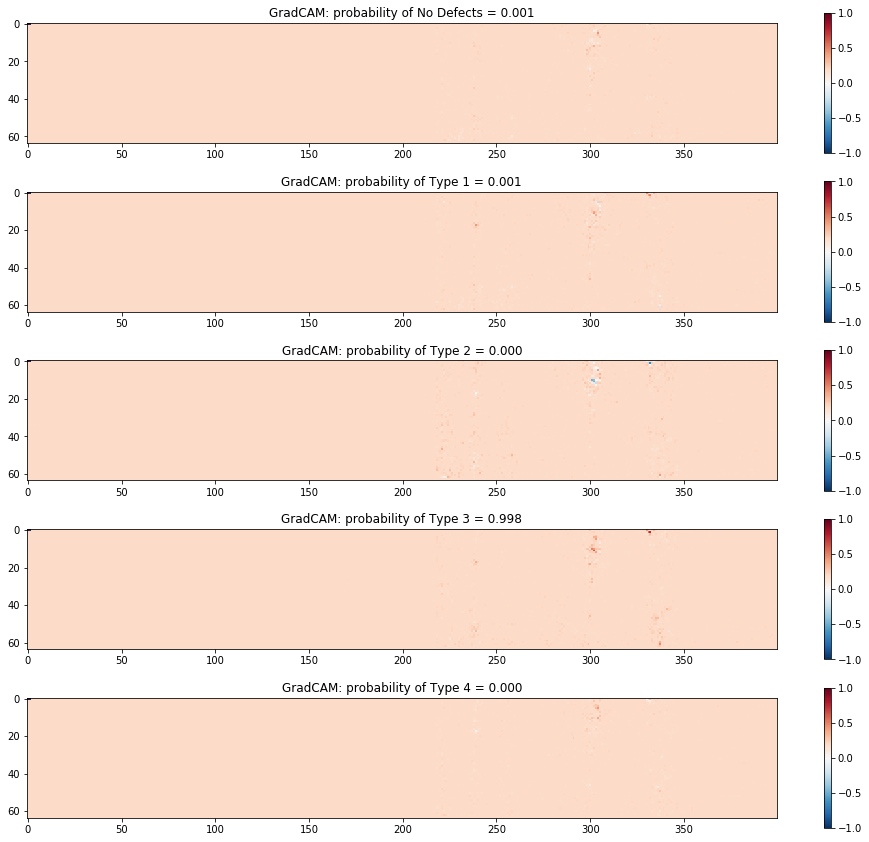

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(4)


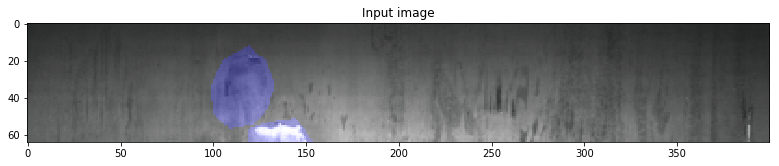

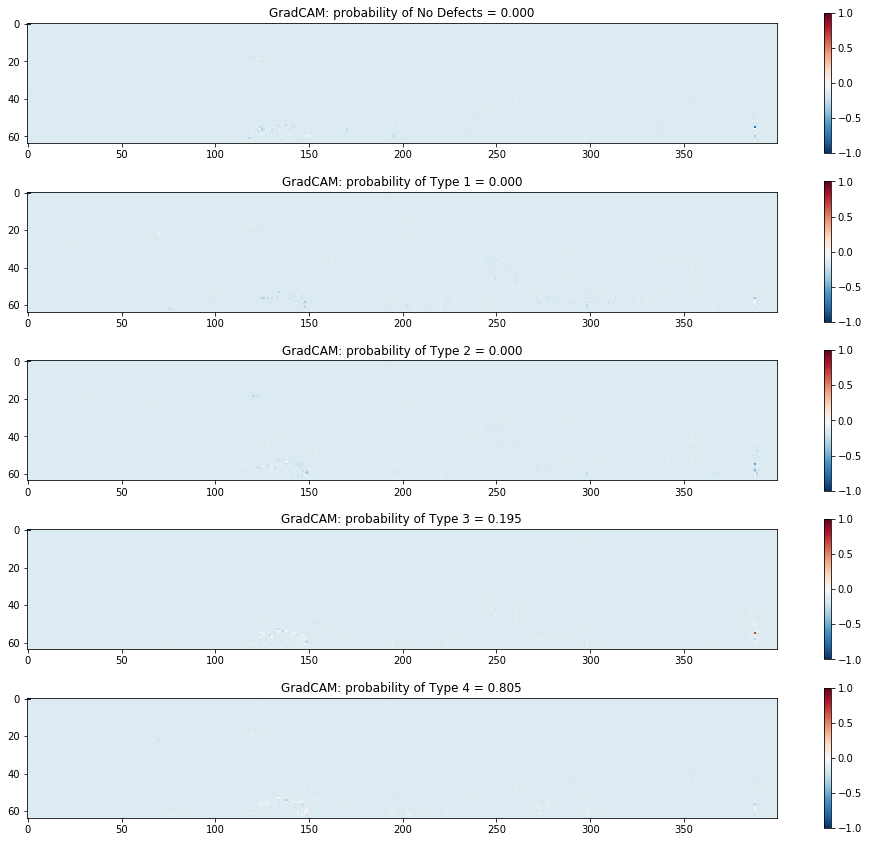

In [118]:
nice_ones = [0, 19, 158, 2, 6]
bad_ones = []
dl_result = []
eg_n = []
for n in nice_ones:
    print(y_val[n])
    res = visualize_deeplift(n, normalizer=True, color_normalizer=False)
    dl_result.append(res)
    eg_n.append(n)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


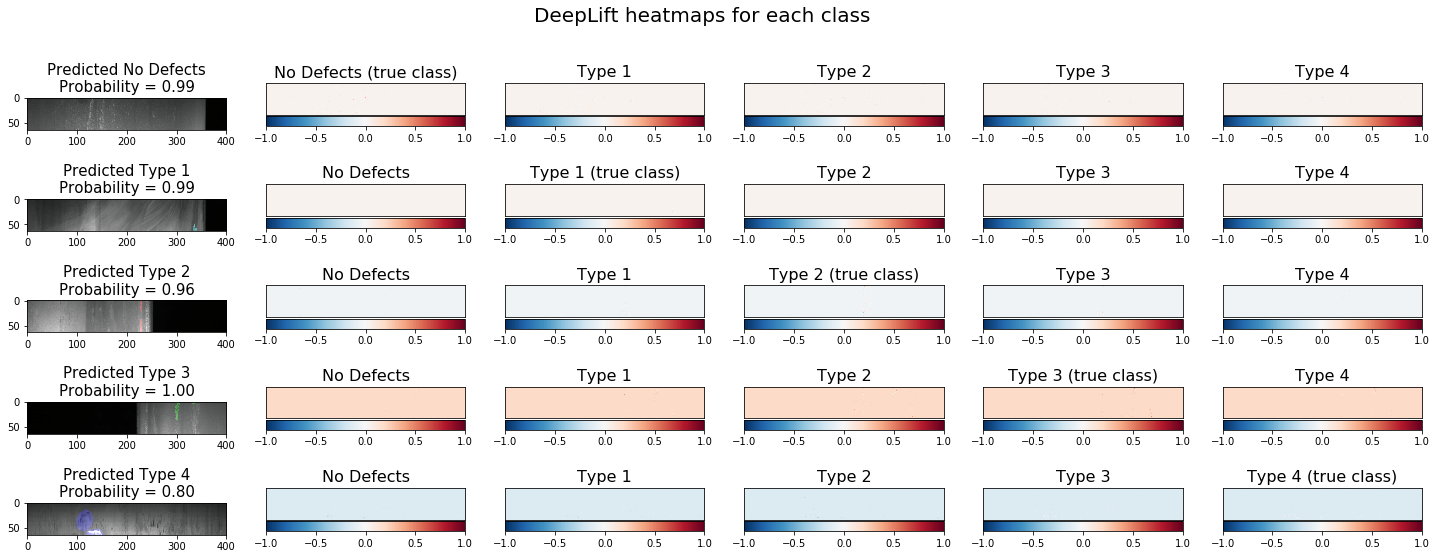

In [119]:
fig = plt.figure(figsize=(25, 9))
fig.suptitle('DeepLift heatmaps for each class', fontsize=20)

for j in range(len(gc_result)):
    ax0 = fig.add_subplot(len(dl_result), 6, j*6+1)
    img = np.transpose(X_val[eg_n[j]].numpy(), (1,2,0))*params['std'] + params['mean']
    if y_val[eg_n[j]] > 0:
        mask = M_val[eg_n[j]].reshape(*params['size'])
        img[mask == 1] = img[mask == 1] + params['colors'][int(y_true[eg_n[j]])-1]
    ax0.imshow(img)

    ax0.set_title('Predicted {}\nProbability = {:.2f}'.format(class_labels[y_pred[eg_n[j]]], 
                                                                  y_score[eg_n[j], int(y_pred[eg_n[j]])]),
                 fontsize=15)
    for i in range(5):
        ax1 = fig.add_subplot(len(gc_result), 6, j*6 + i+2)
        fax1 = ax1.imshow(dl_result[j][i], cmap=plt.cm.RdBu_r)
        plt.colorbar(fax1, ax=ax1, orientation='horizontal', fraction=0.47, pad=0.02)
        ax1.set_xticks([], [])
        ax1.set_yticks([], [])
        if y_val[eg_n[j]] == i:
            ax1.set_title('{} (true class)'.format(class_labels[i]), fontsize=16)
        else:
            ax1.set_title('{}'.format(class_labels[i]), fontsize=16)

### LIME

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


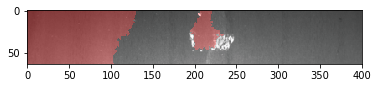

In [12]:
def predict(x):
    x = torch.tensor(np.transpose(x, (0, 3, 1, 2))).to(device)
    x.detach()
    out = net(x)
    probs = nn.Softmax(dim=1)(out).detach().cpu().numpy()
    return probs
    
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.transpose(X_val[n].squeeze(0).numpy(), (1,2,0)), 
                                         predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=10)#progress_bar=False)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
temp[mask == 1] = temp[mask == 1] + np.array(params['colors'][1])*5
plt.imshow(temp*params['std'] + params['mean'])
plt.show()

### DeepSHAP

Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


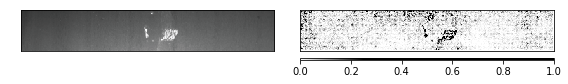

In [13]:
np.random.seed(0)

from matplotlib.colors import LinearSegmentedColormap
gradient_shap = DeepLiftShap(net)
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

input = X_val[n].unsqueeze(0).to(device)
transformed_img = np.transpose(input.squeeze(0).cpu().numpy(), (1, 2, 0))*params['std'] + params['mean']

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])
background = X_val[n+1:n+20]

output_ds = gradient_shap.attribute(input,
                                    #n_samples=50,
                                    #stdevs=0.0001,
                                    baselines=rand_img_dist,
                                    target=y_val[n]).cpu().detach().squeeze()
_ = visualization.visualize_image_attr_multiple(np.transpose(output_ds.numpy(), (1,2,0)),
                                      transformed_img,
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

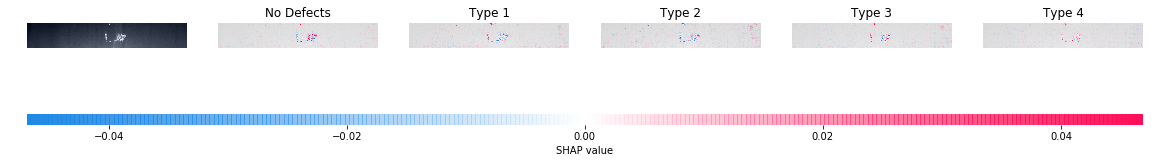

In [14]:
### 7.2.a) Define Backgrund using the next 15 following images in the batch
background = X_val[n+1:n+40].to(device)
### 7.2.b) Init the explainer passing to it the Network and the backgorund
e = shap.DeepExplainer(net.to(device), background)
inp_img = X_val[n].view(1, *list(X_val[n].shape))

### 7.2.c) Compute the shap values for the input X. Input must be 4D (B, C, H, W) and in GPU.
shap_values = e.shap_values(inp_img.to(device)) 

### 7.2.d) Display results
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]                  ### Reshape shap values
test_numpy = np.swapaxes(np.swapaxes(inp_img.cpu().numpy(), 1, -1), 1, 2)                     ### Reshape input example
test_numpy = (test_numpy - test_numpy.min()) / (test_numpy.max() - test_numpy.min())          ### Normalize     
class_labels_shap = np.array([i for i in class_labels.values()]).reshape(1, n_classes)        ### Define Class Labels
shap.image_plot(shap_numpy, test_numpy, class_labels_shap, figsize=(20, 8))                 ### Plot

### IntegratedGradients

In [15]:
ig = IntegratedGradients(net)
baseline = torch.zeros((1, 3, 64, 400)).to(device)
baseline.requires_grad = True
### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
output_ig = ig.attribute(X_val[n].unsqueeze(0).to(device), baseline, y_val[n]).squeeze().detach().sum(axis=0).cpu()

### GuidedGradCam

In [39]:
bp = GuidedGradCam(net, net.classifier[1])
output_bp = bp.attribute(X_val[n].unsqueeze(0).to(device), y_val[n]).squeeze().detach().sum(axis=0).cpu()
output_bp.std()

tensor(0.0236)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


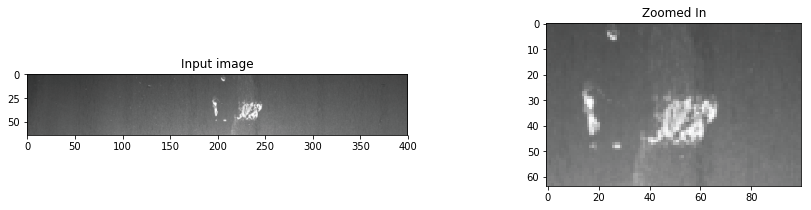

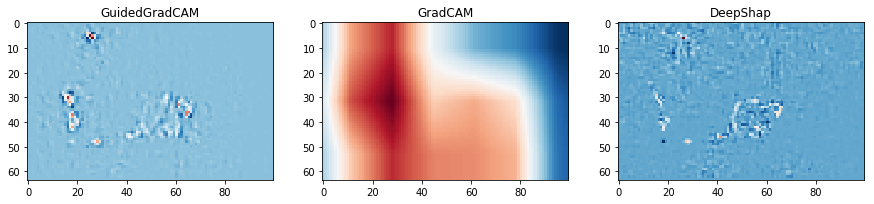

In [40]:
fig = plt.figure(figsize=(15, 3))
ax00 = fig.add_subplot(1,2,1)
ax00.set_title('Input image')
img = np.transpose(X_val[n].numpy(), (1,2,0))*params['std'] + params['mean']
if y_val[n] > 0:
    mask = M_val[n].reshape(*params['size'])
    img[mask == 1] = img[mask == 1] + params['colors'][int(y_true[n])-1]
ax00.imshow(img)
ax01 = fig.add_subplot(1,2,2)


start, end = 180, 280
ax01.imshow(img[:, start:end])
ax01.set_title('Zoomed In')

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(output_bp[:, start:end], cmap=plt.cm.RdBu_r)
ax1.set_title('GuidedGradCAM')
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(res[y_val[n]][:, start:end], cmap=plt.cm.RdBu_r)
ax2.set_title('GradCAM')
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(output_ds.mean(axis=0)[:, start:end], cmap=plt.cm.RdBu_r)
ax3.set_title('DeepShap')
plt.show()

### Multiple inputs - Analysis of wrong classifcation

In [94]:
c = 2
fp = y_pred[(y_pred == c) & (y_true != c)]
fn = y_pred[(y_pred != c) & (y_true == c)]
print(fp.shape[0], fn.shape[0])

index = np.arange(0, y_pred.shape[0])
fp_index = index[(y_pred == c) & (y_true != c)]
fn_index = index[(y_pred != c) & (y_true == c)]
print('False Positive: {}'.format(fp_index))
print('False Negative: {}'.format(fn_index))

39 6
False Positive: [  21   57  105  113  190  285  367  386  389  625  649  664  688  704
 1037 1051 1090 1105 1295 1384 1411 1470 1552 1683 1705 1725 1728 1804
 1876 1937 1945 1947 1964 2006 2010 2020 2022 2126 2227]
False Negative: [ 110  385  605  935  964 1516]


In [88]:
fp_34 = index[(y_pred == 3) & (y_true == 4)][:5]
fp_43 = index[(y_pred == 4) & (y_true == 3)][:5]
fp_34_res, fp_43_res = [], [] 
print(fp_43, fp_34)

[162 184 294 669 694] [ 870 1348 1555 2176 2203]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	False
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	0.00


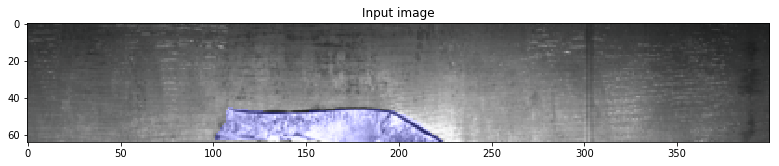

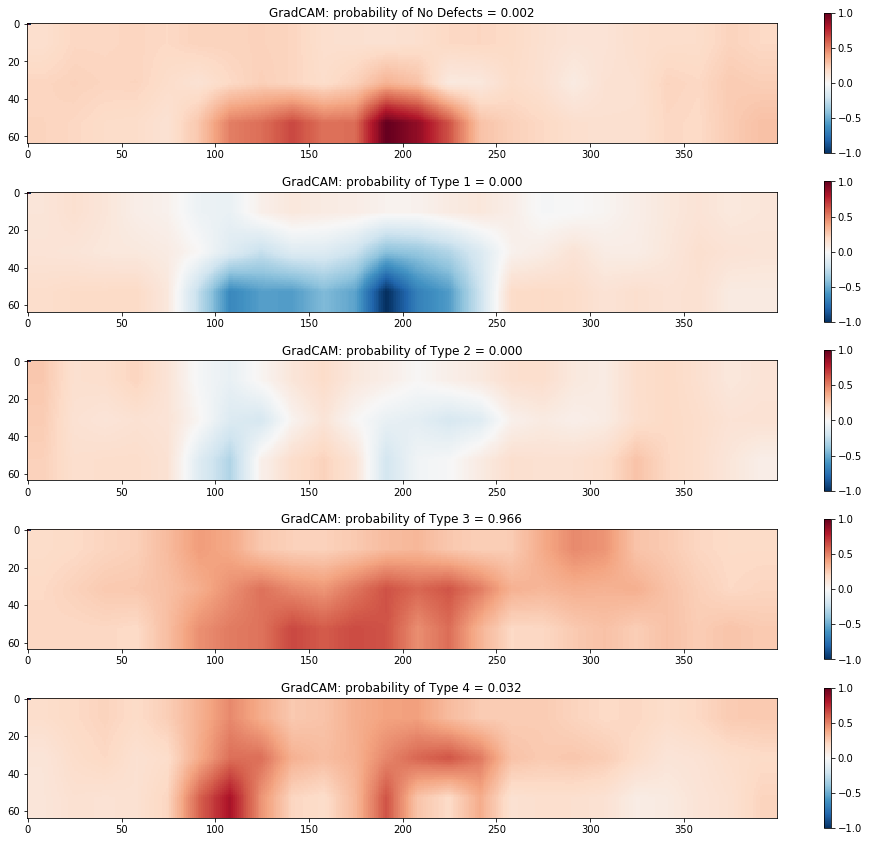

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	False
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	0.00


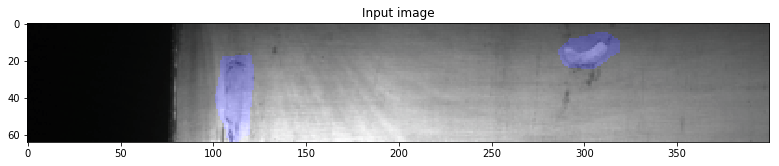

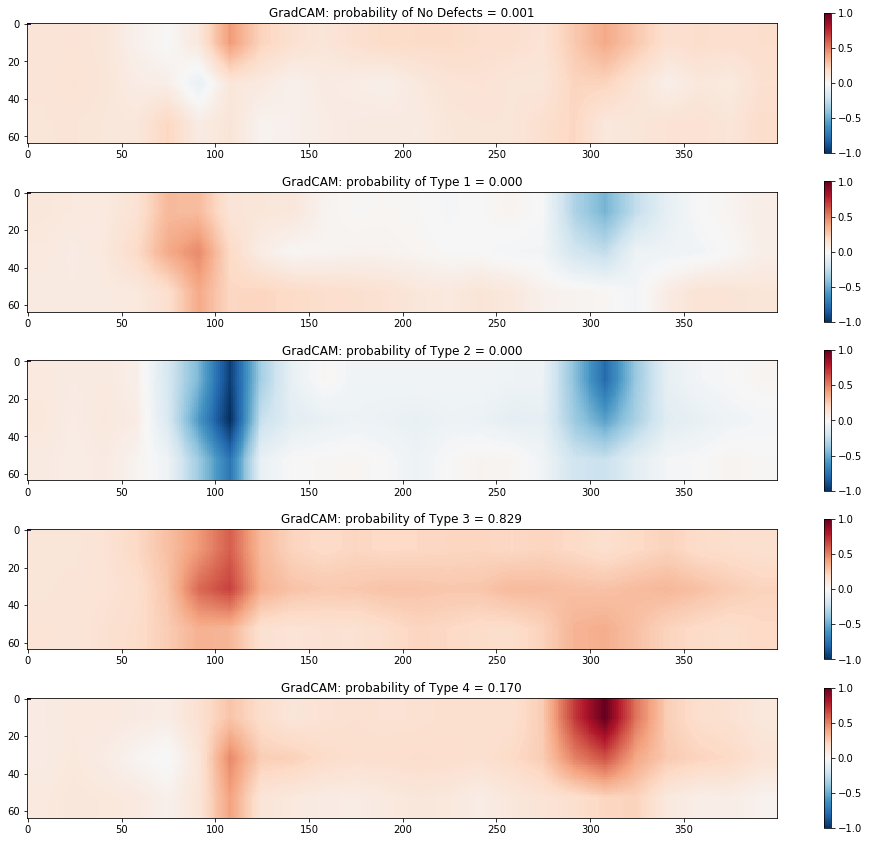

The model predicted correctly:	False
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	0.00


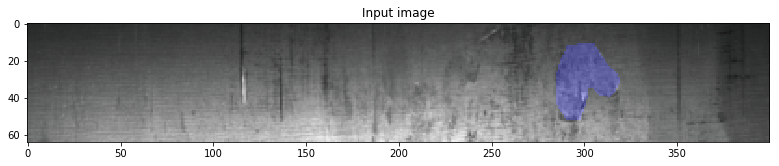

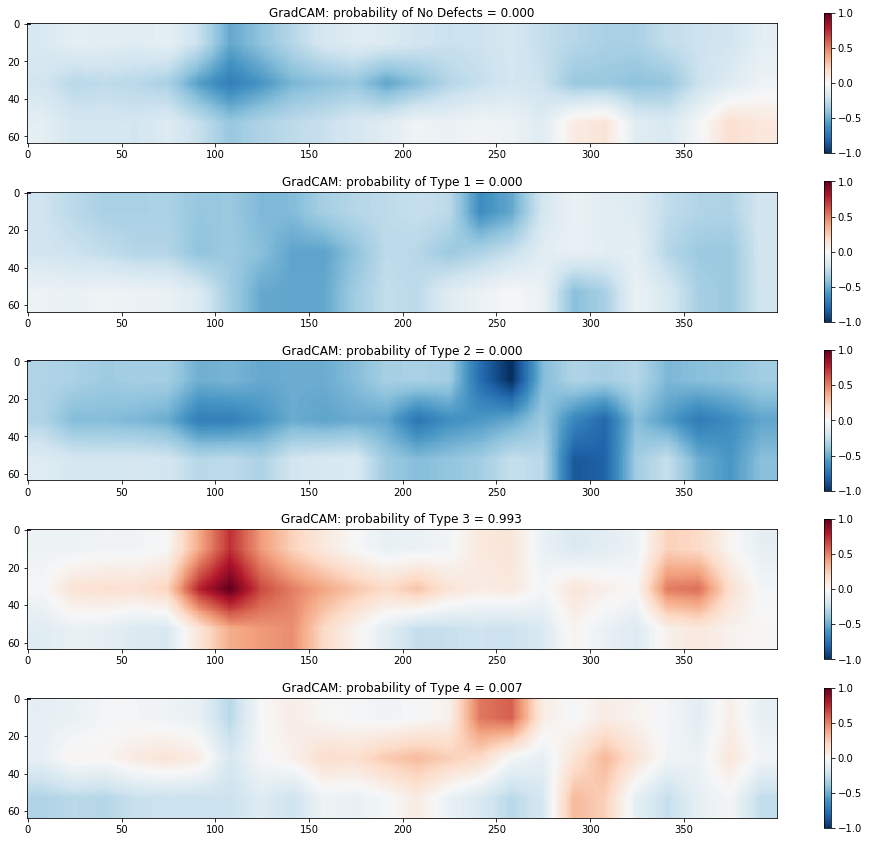

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	False
Predicted No Defects with probability:	0.22
Predicted Defects with probabability:	0.00


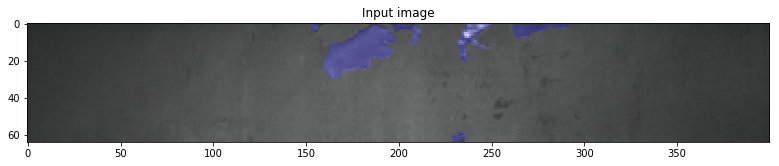

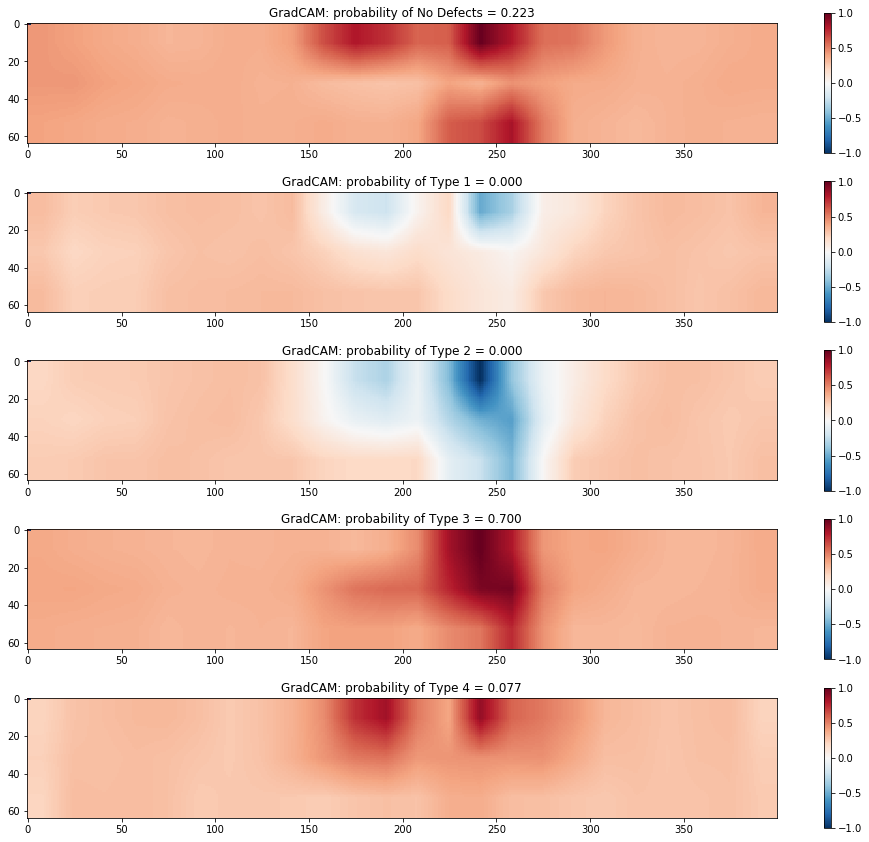

The model predicted correctly:	False
Predicted No Defects with probability:	0.02
Predicted Defects with probabability:	0.00


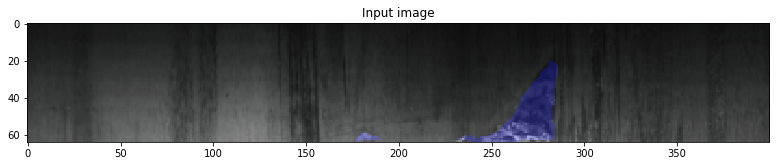

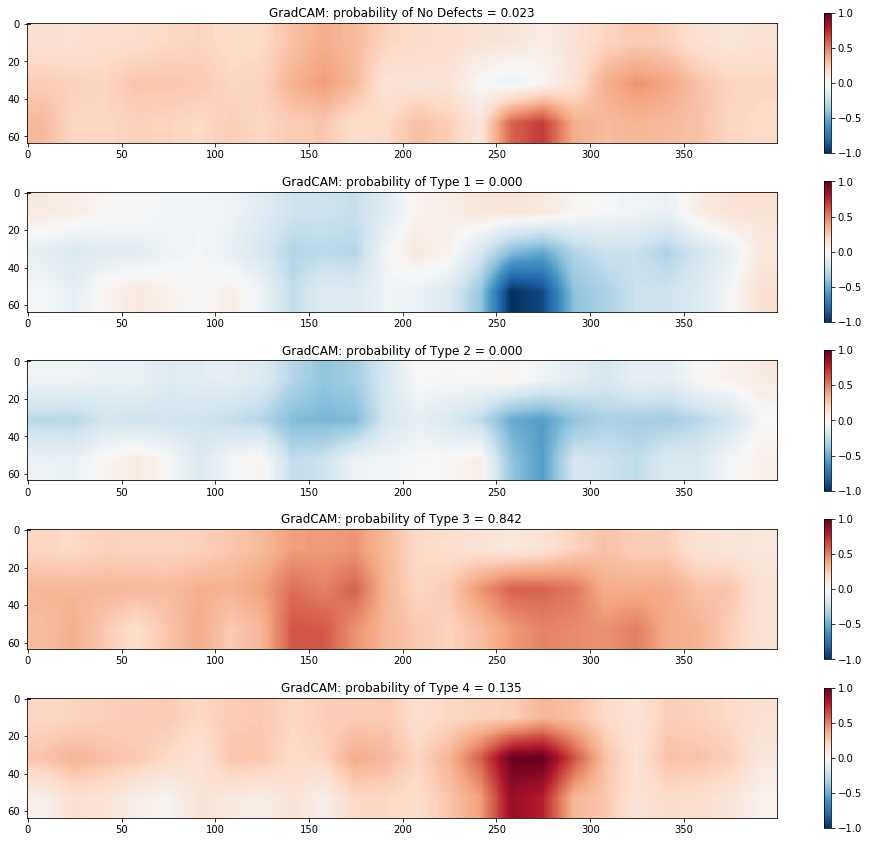

In [91]:
for n in fp_34:
    print('The model predicted correctly:\t{}'.format(y_pred[n] == y_true[n]))
    print('Predicted No Defects with probability:\t{:.2f}'.format(y_score[n, 0]))
    print('Predicted Defects with probabability:\t{:.2f}'.format(y_score[n, 1]))
    #visualize_input(n)
    res = visualize_gradcam(n, module = net.classifier[1], normalizer=True, color_normalizer=False)
    fp_34_res.append(res)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


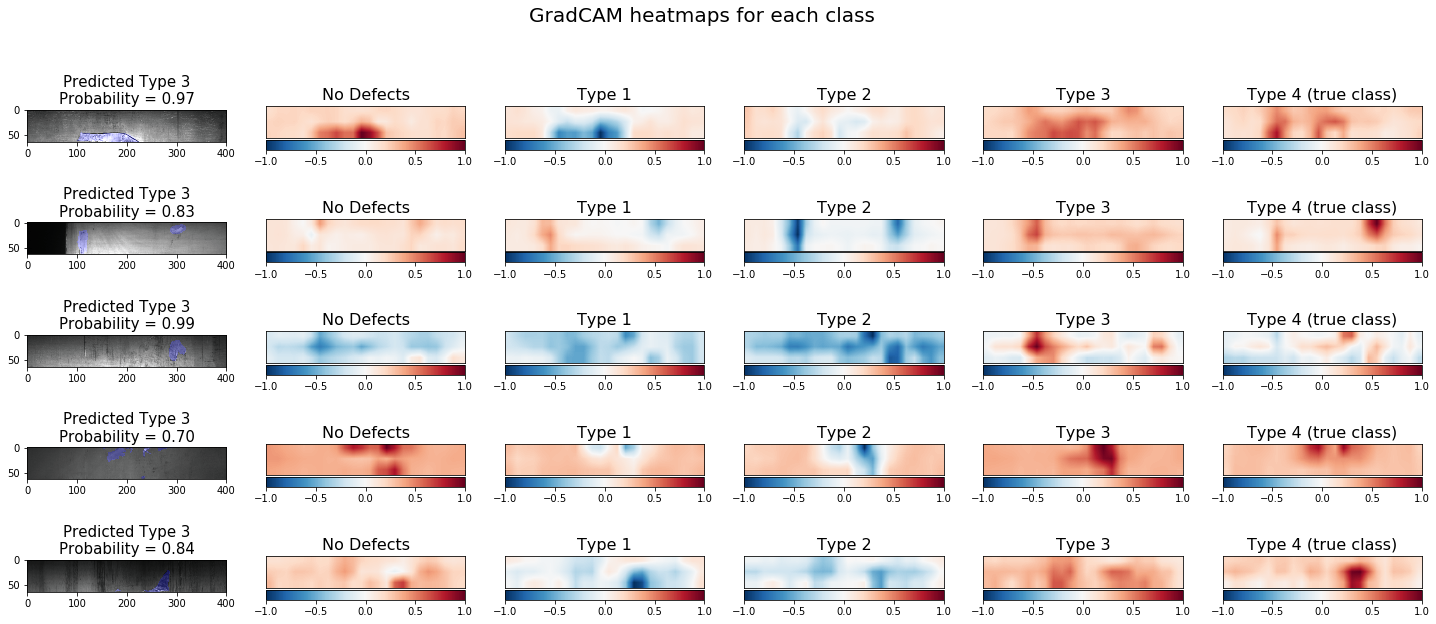

In [93]:
gc_result = fp_34_res
eg_n = fp_34

fig = plt.figure(figsize=(25, 2*len(gc_result)))
fig.suptitle('GradCAM heatmaps for each class', fontsize=20)

for j in range(len(gc_result)):
    ax0 = fig.add_subplot(len(gc_result), 6, j*6+1)
    img = np.transpose(X_val[eg_n[j]].numpy(), (1,2,0))*params['std'] + params['mean']
    if y_val[eg_n[j]] > 0:
        mask = M_val[eg_n[j]].reshape(*params['size'])
        img[mask == 1] = img[mask == 1] + params['colors'][int(y_true[eg_n[j]])-1]
    ax0.imshow(img)

    ax0.set_title('Predicted {}\nProbability = {:.2f}'.format(class_labels[y_pred[eg_n[j]]], 
                                                                  y_score[eg_n[j], int(y_pred[eg_n[j]])]),
                 fontsize=15)
    for i in range(5):
        ax1 = fig.add_subplot(len(gc_result), 6, j*6 + i+2)
        fax1 = ax1.imshow(gc_result[j][i], cmap=plt.cm.RdBu_r)
        plt.colorbar(fax1, ax=ax1, orientation='horizontal', fraction=0.35, pad=0.02)
        ax1.set_xticks([], [])
        ax1.set_yticks([], [])
        if y_val[eg_n[j]] == i:
            ax1.set_title('{} (true class)'.format(class_labels[i]), fontsize=16)
        else:
            ax1.set_title('{}'.format(class_labels[i]), fontsize=16)

### Type  2

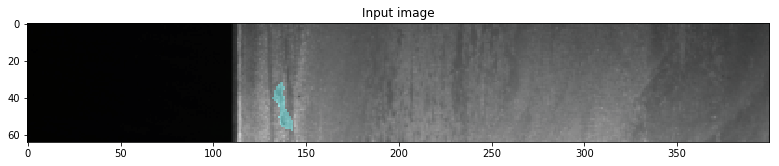

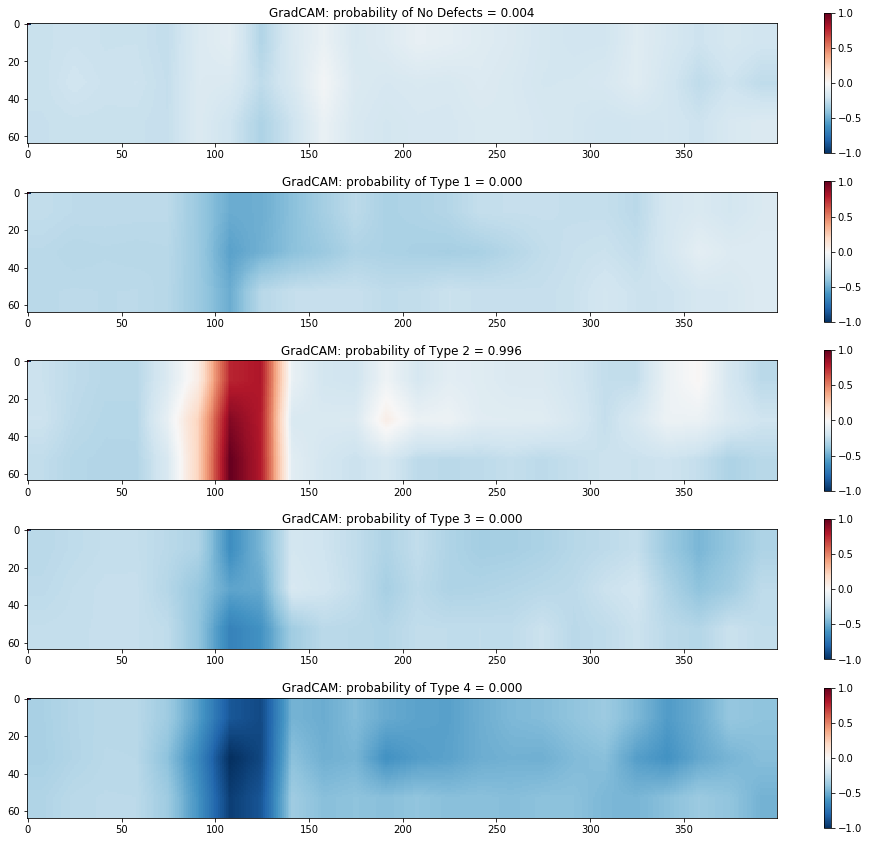

In [106]:
n = fp_21[-1]
res = visualize_gradcam(n, module = net.classifier[1], normalizer=True, color_normalizer=False)

tensor([[7.0773e-01, 2.7197e-02, 2.5714e-01, 7.9276e-03, 6.4277e-06]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)


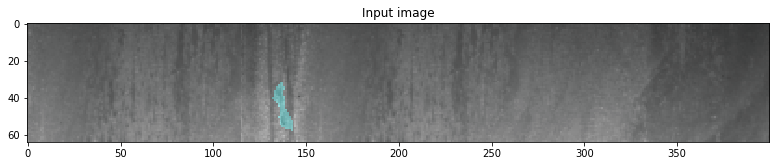

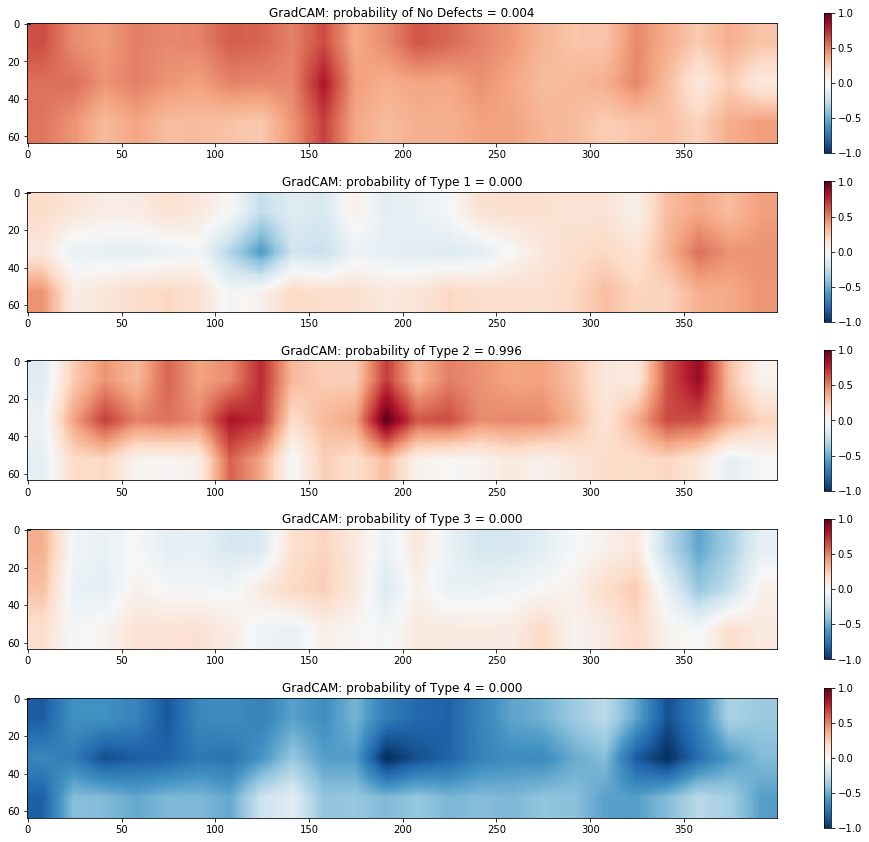

In [117]:
#plt.imshow(np.transpose(X_val[n, :, :, :115].numpy(), (1, 2, 0)))
X_val[n, :, :, :115] = X_val[n, :, :, 150:265]
print(nn.Softmax(1)(net(X_val[n].unsqueeze(0).to(device))))
res = visualize_gradcam(n, module = net.classifier[1], normalizer=True, color_normalizer=False)

### Segmentation Evaluation 

In [12]:
def mask_score(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    
    y = y_true + y_pred
    tp = y[y==2].shape[0]
    tn = y[y==0].shape[0]
    fp = y[(y_true == 0) & (y_pred == 1)].shape[0]
    fn = y[(y_true == 1) & (y_pred == 0)].shape[0]
    
    return {'accuracy': (tp+tn)/(tp+tn+fp+fn),'recall': (0.01 + tp)/(0.01 + tp+fn), 
            'precision': (0.01 + tp)/(0.01+tp+fp), 'IoU': (0.01+tp)/(0.01+tp+fp+fn),
            'dice_score': (2*tp/(y_true.sum()+y_pred.sum()))} 

In [13]:
X, Y, M = X_val[y_val != 0], y_val[y_val != 0], M_val[y_val != 0]

### DeepLift

In [80]:
dl = DeepLift(net)
baseline = torch.zeros((1, 3, 64, 400)).to(device)
baseline.requires_grad = True
accuracy, recall, precision, dice, iou = [], [], [], [], []
    
blur_baseline = True
for i in tqdm(range(X.shape[0])):
    if blur_baseline:
        baseline = np.transpose(X[i].clone().numpy(), (1, 2, 0))
        baseline = cv2.blur(baseline, (3, 3))
        baseline = torch.tensor(np.transpose(baseline, (2, 0, 1))).unsqueeze(0).to(device)
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = dl.attribute(x.unsqueeze(0).to(device), baseline, Y[i]).squeeze().detach().sum(axis=0).cpu()
    mean_out = 0 + 3*output.std() 
    output[output > mean_out] = 1
    output[output <= mean_out] = 0
    b_out = cv2.blur(output.numpy(), ksize=(7, 7))
    b_out[b_out > 0] = 1
    b_out[b_out <= 0] = 0
    res = mask_score(M[i].numpy(), b_out)
    accuracy.append(res['accuracy'])
    recall.append(res['recall'])
    precision.append(res['precision'])
    dice.append(res['dice_score'])
    iou.append(res['IoU'])
np.mean(accuracy), np.mean(recall), np.mean(precision), np.mean(dice), np.mean(iou)

100%|██████████████████████████████████████████████████████████████████████████████| 1288/1288 [02:52<00:00,  7.47it/s]


(0.8804404236218943,
 0.7599217212175382,
 0.2566574096209716,
 0.31558884192128756,
 0.2041583474747928)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


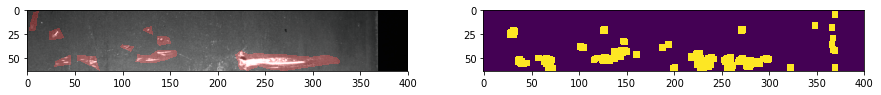

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + params['colors'][1]
ax[0].imshow(img)
ax[1].imshow(b_out)
plt.show()

### Integrated Gradient

In [23]:
ig = IntegratedGradients(net)
baseline = torch.zeros((1, 3, 64, 400)).to(device)
baseline.requires_grad = True
accuracy_ig, recall_ig, precision_ig, dice_ig, iou_ig = [], [], [], [], []

blur_baseline = True
for i in tqdm(range(X.shape[0])):
    if blur_baseline:
        baseline = np.transpose(X[i].clone().numpy(), (1, 2, 0))
        baseline = cv2.blur(baseline, (3, 3))
        baseline = torch.tensor(np.transpose(baseline, (2, 0, 1))).unsqueeze(0).to(device)
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = ig.attribute(x.unsqueeze(0).to(device), baseline, Y[i]).squeeze().detach().sum(axis=0).cpu()
    x.detach().cpu()
    b_out = cv2.blur(output.numpy(), ksize=(5, 5))
    b_out[b_out > 0] = 1
    b_out[b_out <= 0] = 0
    res = mask_score(M[i].numpy(), b_out)
    accuracy_ig.append(res['accuracy'])
    recall_ig.append(res['recall'])
    precision_ig.append(res['precision'])
    dice_ig.append(res['dice_score'])
    iou_ig.append(res['IoU'])
np.mean(accuracy_ig), np.mean(recall_ig), np.mean(precision_ig), np.mean(dice_ig), np.mean(iou_ig)

100%|██████████████████████████████████████████████████████████████████████████████| 1288/1288 [05:38<00:00,  3.80it/s]


(0.5200742733404503,
 0.7141261525910115,
 0.07462458921546793,
 0.11468324910133586,
 0.06578090005516317)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


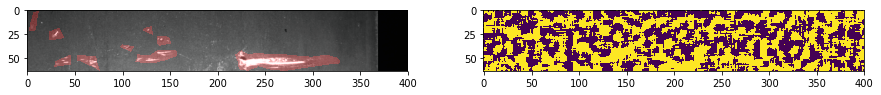

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + params['colors'][1]
ax[0].imshow(img)
ax[1].imshow(b_out)
plt.show()

### GuidedBackProp

In [21]:
bp = GuidedBackprop(net)
accuracy_bp, recall_bp, precision_bp, dice_bp, iou_bp = [], [], [], [], []
    
for i in tqdm(range(X.shape[0])):
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = bp.attribute(x.unsqueeze(0).to(device), Y[i]).squeeze().detach().mean(axis=0).cpu()
    x.detach().cpu()
    mean_out = 0 + 3*output.std() 
    output[output > mean_out] = 1
    output[output <= mean_out] = 0
    b_out = cv2.blur(output.numpy(), ksize=(5, 5))
    b_out[b_out > 0] = 1
    b_out[b_out <= 0] = 0
    res = mask_score(M[i].numpy(), b_out)
    accuracy_bp.append(res['accuracy'])
    recall_bp.append(res['recall'])
    precision_bp.append(res['precision'])
    dice_bp.append(res['dice_score'])
    iou_bp.append(res['IoU'])
np.mean(accuracy_bp), np.mean(recall_bp), np.mean(precision_bp), np.mean(dice_bp), np.mean(iou_bp)

100%|██████████████████████████████████████████████████████████████████████████████| 1288/1288 [00:54<00:00, 23.62it/s]


(0.9050166804153728,
 0.6382010660912372,
 0.28501143265794127,
 0.3153114437172216,
 0.19878025600066526)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


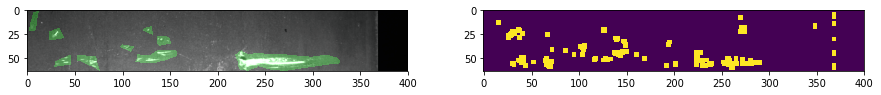

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + params['colors'][Y[i]-1]
ax[0].imshow(img)
ax[1].imshow(b_out)
plt.show()

### GuidedGradCam

In [45]:
ggc = GuidedGradCam(net, net.classifier[1])
accuracy_ggc, recall_ggc, precision_ggc, dice_ggc, iou_ggc = [], [], [], [], []
    
for i in tqdm(range(X[:34].shape[0])):
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = ggc.attribute(x.unsqueeze(0).to(device), Y[i]).squeeze().detach().mean(axis=0).cpu()
    x.detach().cpu()
    mean_out = 0 + 3*output.std() 
    output[output > mean_out] = 1
    output[output <= mean_out] = 0
    b_out = cv2.blur(output.numpy(), ksize=(5, 5))
    b_out[b_out > 0] = 1
    b_out[b_out <= 0] = 0
    
    res = mask_score(M[i].numpy(), b_out)
    accuracy_ggc.append(res['accuracy'])
    recall_ggc.append(res['recall'])
    precision_ggc.append(res['precision'])
    dice_ggc.append(res['dice_score'])
    iou_ggc.append(res['IoU'])
np.mean(accuracy_ggc), np.mean(recall_ggc), np.mean(precision_ggc), np.mean(dice_ggc), np.mean(iou_ggc)

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.35it/s]


(0.9444829963235295,
 0.4756431814472355,
 0.39267073325725477,
 0.3479358408274943,
 0.22823148264650084)

In [46]:
iou_ggc

[0.026914556820118205,
 0.40756644997117353,
 0.030425420615320983,
 0.495280429277277,
 0.22672950231847516,
 0.0995162609235377,
 0.04910299783353433,
 0.21924358403107064,
 0.24868081034545103,
 0.11899149257784057,
 0.1212898351921433,
 0.16205147556630892,
 0.10105576735060794,
 0.32554626497308564,
 0.2791998015042569,
 7.423849860060431e-06,
 0.13637090596880497,
 0.30829493596755836,
 0.4191534816915912,
 0.31408858371245413,
 0.2412808903399349,
 0.21633656282354524,
 0.4978750113031314,
 0.15201130651591313,
 0.35946294911529425,
 0.29708455873820044,
 0.15903783613415282,
 0.023115159130341373,
 0.5878523164834443,
 0.3804421351049758,
 0.3638155827087361,
 0.09728401436600106,
 0.059990510380390515,
 0.23477159634649733]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


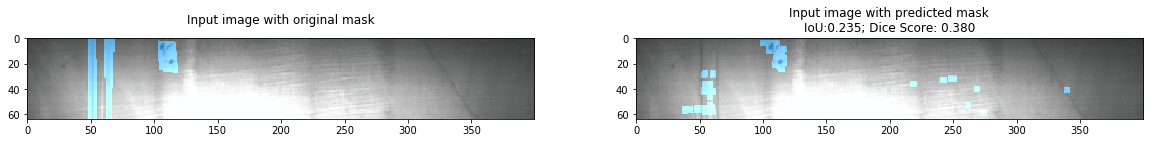

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
img_pred = img.copy()
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + [0.0, 0.3, 0.5]
img_pred[b_out == 1] = img_pred[b_out == 1] + [0.0, 0.3, 0.5]
ax[0].imshow(img)
ax[1].imshow(img_pred)
ax[0].set_title('Input image with original mask', y=1.1)
ax[1].set_title('Input image with predicted mask\nIoU:{:.3f}; Dice Score: {:.3f}'.format(iou_ggc[-1], dice_ggc[-1]))
plt.show()

### GradCam

In [26]:
gc = LayerGradCam(net, net.classifier[1])
accuracy_gc, recall_gc, precision_gc, dice_gc, iou_gc = [], [], [], [], []
    
for i in tqdm(range(X.shape[0])):
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = gc.attribute(x.unsqueeze(0).to(device), Y[i], relu_attributions=True).squeeze().detach().cpu().numpy()
    output = cv2.resize(output, (400, 64))
    x.detach().cpu()
    mean_out = 0 + 3*output.std() 
    output[output > mean_out] = 1
    output[output <= mean_out] = 0
    b_out = cv2.blur(output, ksize=(5, 5))
    b_out[b_out > 0] = 1
    b_out[b_out <= 0] = 0
    
    res = mask_score(M[i].numpy(), b_out)
    accuracy_gc.append(res['accuracy'])
    recall_gc.append(res['recall'])
    precision_gc.append(res['precision'])
    dice_gc.append(res['dice_score'])
    iou_gc.append(res['IoU'])
np.mean(accuracy_gc), np.mean(recall_gc), np.mean(precision_gc), np.mean(dice_gc), np.mean(iou_gc)

100%|██████████████████████████████████████████████████████████████████████████████| 1288/1288 [00:24<00:00, 52.95it/s]


(0.897904727532997,
 0.49938186185149164,
 0.22289641954655648,
 0.23550667675417458,
 0.14365166813300895)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


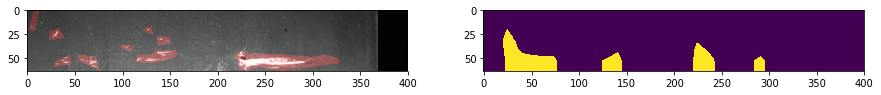

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + params['colors'][1]
ax[0].imshow(img)
ax[1].imshow(output)
plt.show()

### LIME

In [15]:
accuracy_rn, recall_rn, precision_rn, dice_rn, iou_rn = [], [], [], [], []
for i in range(200):
    mask = np.random.randint(0, 2, (64, 400))
    res = mask_score(M[i].numpy(), mask)
    accuracy_rn.append(res['accuracy'])
    recall_rn.append(res['recall'])
    precision_rn.append(res['precision'])
    dice_rn.append(res['dice_score'])
    iou_rn.append(res['IoU'])
np.mean(accuracy_rn), np.mean(recall_rn), np.mean(precision_rn), np.mean(dice_rn), np.mean(iou_rn)

(0.49967734375,
 0.500625059541584,
 0.055180545985528795,
 0.08716288990418723,
 0.048396079893733616)

In [16]:
def predict(x):
    x = torch.tensor(np.transpose(x, (0, 3, 1, 2))).to(device)
    x.detach()
    out = net(x)
    probs = nn.Softmax(dim=1)(out).detach().cpu().numpy()
    return probs
explainer = lime_image.LimeImageExplainer()
accuracy_lime, recall_lime, precision_lime, dice_lime, iou_lime = [], [], [], [], []
    
for i in tqdm(range(X.shape[0])):
    with torch.no_grad():
        net.eval()
        explanation = explainer.explain_instance(np.transpose(X_val[i].squeeze(0).numpy(), (1,2,0)), 
                                             predict, # classification function
                                             top_labels=1, 
                                             hide_color=0, 
                                             num_samples=20)
                                             ##progress_bar=False)
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                    positive_only=True, 
                                                    num_features=5, 
                                                    hide_rest=False)
        res = mask_score(M[i].numpy(), mask)
        accuracy_lime.append(res['accuracy'])
        recall_lime.append(res['recall'])
        precision_lime.append(res['precision'])
        dice_lime.append(res['dice_score'])
        iou_lime.append(res['IoU'])
np.mean(accuracy_lime), np.mean(recall_lime), np.mean(precision_lime), np.mean(dice_lime), np.mean(iou_lime)

100%|██████████████████████████████████████████████████████████████████████████████| 1288/1288 [14:08<00:00,  1.52it/s]


(0.72106208753882,
 0.25702578422440336,
 0.12659285165382034,
 0.0713542912498483,
 0.040500992020679916)

### NoiseGradCam

In [14]:
gc = LayerGradCam(net, net.classifier[1])
nt = NoiseTunnel(gc)
accuracy_gc, recall_gc, precision_gc, dice_gc = [], [], [], []
    
for i in tqdm(range(X.shape[0])):
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = nt.attribute(x.unsqueeze(0).to(device), target=Y[i], n_samples=20, stdevs = 0.1).squeeze().detach().cpu().numpy()
    #output = gc.attribute(x.unsqueeze(0).to(device), target=Y[i]).squeeze().detach().cpu().numpy()
    output = cv2.resize(output, (400, 64))
    x.detach().cpu()
    mean_out = 0 + 1*output.std() 
    output[output > mean_out] = 1
    output[output <= mean_out] = 0
    b_out = cv2.blur(output, ksize=(5, 5))
    b_out[b_out > 0] = 1
    b_out[b_out <= 0] = 0
    
    res = mask_score(M[i].numpy(), output)
    accuracy_gc.append(res['accuracy'])
    recall_gc.append(res['recall'])
    precision_gc.append(res['precision'])
    dice_gc.append(res['dice_score'])
np.mean(accuracy_gc), np.mean(recall_gc), np.mean(precision_gc), np.mean(dice_gc)

100%|██████████████████████████████████████████████████████████████████████████████| 1326/1326 [00:56<00:00, 23.30it/s]


(0.8281144242552791,
 0.6346695739797389,
 0.14316220304329474,
 0.11646669905000043)

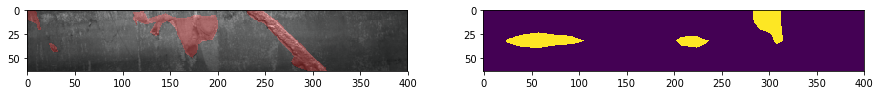

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + params['colors'][1]
ax[0].imshow(img)
ax[1].imshow(output)
plt.show()

### DeepShap

In [14]:
dl = DeepLiftShap(net)
baseline = X_val[:25].to(device)
baseline.requires_grad = True
accuracy, recall, precision, dice, iou = [], [], [], [], []
    
for i in tqdm(range(X[25:].shape[0])):
    x = X[i]
    x.requires_grad = True
    ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
    output = dl.attribute(x.unsqueeze(0).to(device), baseline, Y[i]).squeeze().detach().mean(axis=0).cpu().numpy()
    x.detach()
    mean_out = 0 + 3*output.std() 
    output[output > mean_out] = 1
    output[output <= mean_out] = 0
    b_out = cv2.blur(output, ksize=(5, 5))
    b_out[b_out > 0] = 1
    b_out[b_out <= 0] = 0
    res = mask_score(M[i].numpy(), b_out)
    accuracy.append(res['accuracy'])
    recall.append(res['recall'])
    precision.append(res['precision'])
    dice.append(res['dice_score'])
    iou.append(res['IoU'])
np.mean(accuracy), np.mean(recall), np.mean(precision), np.mean(dice), np.mean(iou)

100%|██████████████████████████████████████████████████████████████████████████████| 1263/1263 [11:21<00:00,  1.85it/s]


(0.8844662076900237,
 0.5410394062755227,
 0.22463095829023683,
 0.24333478710673784,
 0.15014208022598483)

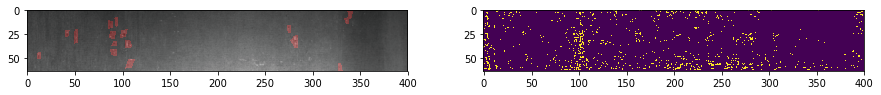

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = np.transpose(x.detach().numpy(), (1,2,0))*params['std'] + params['mean']
mask = M[i].reshape(*params['size'])
img[mask == 1] = img[mask == 1] + params['colors'][1]
ax[0].imshow(img)
ax[1].imshow(output)
plt.show()